## Author
- **Meng-Hsuan (Michelle) Wu** (JHU)

## Projects
- Least Squares Mean Squared Generative Adversarial Network 35 timesteps training

In [ ]:
import os
import os.path
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
import torch.nn as nn
from torch import linalg as LA
from torch import optim
import torch.nn.functional as F
from torch.autograd import grad as torch_grad
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset, random_split,TensorDataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import pickle
import shutil
from torchvision.utils import make_grid
import imageio
from google.colab import drive
drive.mount('/content/drive')
from matplotlib import cm
from math import floor 
from torch.nn.modules.pooling import MaxPool2d
import random


Mounted at /content/drive


# Loading Datapoint

In [ ]:
num_input_pics = 7
tot_pics_series = 100 #100
num_series = 100
img_channel = 3
img_height = 288
img_width = 432


# num_train + num_val + num_test = num_series
num_train = 80 # 80
num_val = 10
num_test = 10
batch_train_num = 8
batch_valid_num = 10
batch_test_num = 10




In [ ]:
seq_train = torch.arange(0, num_train)
seq_val = torch.arange(num_train, num_train + num_val)
seq_test = torch.arange(100, 110)


train_data = TensorDataset(seq_train)
val_data = TensorDataset(seq_val)
test_data = TensorDataset(seq_test)

train_dl = DataLoader(train_data, batch_size = batch_train_num, shuffle = True)
valid_dl = DataLoader(val_data,   batch_size = batch_valid_num, shuffle = False)
test_dl = DataLoader(test_data,   batch_size = batch_test_num, shuffle = False)

# Model (Generator)

## Encoder

In [ ]:
class ConvNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 2, stride = 1), 
        nn.ReLU(),
        nn.BatchNorm2d(64,momentum=0.9),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size = 3, stride = 1), 
        nn.ReLU(),
        nn.BatchNorm2d(128,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(128, 256, kernel_size = 2, stride = 1), 
        nn.ReLU(),
        nn.BatchNorm2d(256,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(256, 256, kernel_size = 2, stride = 1), 
        nn.ReLU(),

        nn.BatchNorm2d(256,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(256, 512, kernel_size = 3, stride = 1), 
        nn.ReLU(),
        nn.Dropout(0.2)
    )
  
  def forward(self, x):
    cnn_val = self.network(x)
    return_val = F.max_pool2d(cnn_val, kernel_size=cnn_val.size()[2:])
    return_val = torch.squeeze(return_val)
    return return_val

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.convNN = ConvNN()
    self.lstm = nn.LSTM(input_size = 512, hidden_size = 512,
                        batch_first = True, bidirectional = True,
                        num_layers = 4, dropout = 0.2)

  def forward(self, input):
    batch_size = int(input.shape[0]/img_length)
    in_features = self.convNN(input) 
    in_features = torch.reshape(in_features,(batch_size, img_length, 512))
    output, (h_n, c_n) = self.lstm(in_features)
    return h_n[-1]

## Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 512, out_channels = 256, 
                               kernel_size = 4, stride = 1, padding = 0, 
                               bias=False), 
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 128, 4, 2, 1, bias=False), 
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), 
            nn.Sigmoid()

        )
    def forward(self, input):
      return self.main(input)

# Discriminator (Critic)

In [ ]:
class Discriminator(nn.Module):
  # img_size = (32, 32, 1)
  # dim = 16 # should be 64
  def __init__(self, img_size, dim):
      super(Discriminator, self).__init__()

      self.img_size = img_size

      self.image_to_features = nn.Sequential(
          nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(dim, 2 * dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          
          nn.Conv2d(4 * dim, 8 * dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(8 * dim, self.img_size[2], 4, 2, 1),
          
          nn.Sigmoid()
      )

      self.features_to_prob = nn.Sequential(
          nn.Linear(192, 1),
          nn.Sigmoid()
      )

  def forward(self, input_data):
    batch_size = input_data.size()[0]
    n_channels = input_data.size()[1]
    x = self.image_to_features(input_data)
    x = x.view(batch_size, -1)
    return self.features_to_prob(x)

# Models

In [ ]:
class CLSTM(nn.Module):
  def __init__(self, latent_dim):
    super(CLSTM, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.latent_dim = latent_dim
  def forward(self, x):
    y_hidden = self.encoder(x) 
    y_hidden = torch.unsqueeze(y_hidden,2)
    y_hidden = torch.unsqueeze(y_hidden,3)
    y_predict = self.decoder(y_hidden)
    return y_predict
  def sample_latent(self, num_samples):
    return torch.randn((num_samples, self.latent_dim))

# Train

In [ ]:
class Trainer():
  def __init__(self, clstm, discriminator, gen_optimizer, dis_optimizer,
               checkpoint_path, backup_model_path, img_channel,img_height,img_width,new_img_height,new_img_width,
               train_mse,val_mse,train_g_loss,train_d_loss,val_g_loss,val_d_loss,
               random_timestep,tot_pics_series, 
               num_input_pics,save_model_every = 200, print_every = 10, 
               use_cuda=True):
    
    self.G = clstm

    self.G_opt = gen_optimizer
    self.D = discriminator
    self.D_opt = dis_optimizer

    self.checkpoint_path = checkpoint_path
    self.backup_model_path = backup_model_path

    self.img_channel = img_channel
    self.old_img_height = img_height
    self.old_img_width = img_width
    self.new_img_height = new_img_height
    self.new_img_width = new_img_width
    
    self.num_input_pics = num_input_pics
    self.tot_pics_series = tot_pics_series
    self.start_time = self.num_input_pics
    self.random_timestep = random_timestep
    

    self.train_mse = train_mse
    self.val_mse = val_mse
    self.train_g_loss = train_g_loss
    self.val_g_loss = val_g_loss
    self.train_d_loss = train_d_loss
    self.val_d_loss = val_d_loss

    self.temp_train_d_loss = []
    self.temp_train_g_loss = []
    self.temp_val_d_loss = []
    self.temp_val_g_loss = []

    self.temp_train_mse = []
    self.temp_val_mse = []

    self.save_model_every = save_model_every
    self.print_every = print_every

    self.use_cuda = use_cuda

    

    if self.use_cuda:
        self.G = self.G.cuda()
        self.D = self.D.cuda()
        
        
  def _critic_train_iteration(self, y_pred, y_true, train):
    batch_size = y_true.size()[0] 
    theoretical_real = torch.ones(batch_size,1) # this is b
    theoretical_fake = torch.zeros(batch_size,1) # this is a
    if self.use_cuda:
      theoretical_real = theoretical_real.cuda()
      theoretical_fake = theoretical_fake.cuda()

    # Calculate probabilities on real and generated data
    d_real = self.D(y_true)
    d_generated = self.D(y_pred)

    # Create total loss and optimize
    if train:
      self.D_opt.zero_grad()
      d_real = d_real.view(batch_size, -1)
      d_generated = d_generated.view(batch_size,-1) 
      real_loss = adversarial_loss(d_real, theoretical_real)
      fake_loss = adversarial_loss(d_generated, theoretical_fake)
      d_loss = (1/2)* (real_loss + fake_loss) 

      d_loss.backward(retain_graph = True)
      self.D_opt.step()
      self.temp_train_d_loss.append(d_loss.data.cpu().numpy())
    else:
      d_real = d_real.view(batch_size, -1)
      d_generated = d_generated.view(batch_size,-1)
      real_loss = adversarial_loss(d_real, theoretical_real)
      fake_loss = adversarial_loss(d_generated, theoretical_fake)
      d_loss = (1/2)* (real_loss + fake_loss)
      self.temp_val_d_loss.append(d_loss.data.cpu().numpy())
  def _generator_train_iteration(self, y_pred, y_true, train):
    batch_size = y_true.size()[0]
    theoretical_real = torch.ones(batch_size,1)
    pixel_diff = adversarial_loss(y_true,y_pred)
    if self.use_cuda:
      theoretical_real = theoretical_real.cuda()
    if train:
      self.G_opt.zero_grad()
      d_generated = self.D(y_pred)
      g_loss = 0.5*(adversarial_loss(d_generated,theoretical_real) + pixel_diff)
      g_loss.backward()
      self.G_opt.step()

      # Record loss
      g_loss = g_loss.data.cpu().numpy()
      self.temp_train_g_loss.append(g_loss)
      self.temp_train_mse.append(pixel_diff)
    else:
      d_generated = self.D(y_pred)
      g_loss = 0.5*(adversarial_loss(d_generated, theoretical_real) + pixel_diff)

      # Record loss
      g_loss = g_loss.data.cpu().numpy()
      self.temp_val_g_loss.append(g_loss)
      self.temp_val_mse.append(pixel_diff)
  def _train_epoch(self,train_loader, train_data):

    self.G.train()

    train_batch_num = 0
    for batch_train in train_loader:
      curr_batch_train = train_data[train_batch_num]
      train_batch_num +=1
      for t in range(len(self.random_timestep)):
        curr_y_time = self.random_timestep[t]
        curr_x_start_time = curr_y_time-self.num_input_pics
        x_train = curr_batch_train[:, curr_x_start_time: curr_y_time,:,:,: ]
        y_train = curr_batch_train[:, curr_y_time, :,:,:]

        
        if self.use_cuda:
          x_train, y_train = x_train.cuda(), y_train.cuda()
        x_train = fn.center_crop(x_train,output_size = [256])

        n_series = x_train.shape[0]

        x_train_new_dim = (n_series*self.num_input_pics, self.img_channel, self.new_img_height, self.new_img_width)
        x_train_new = torch.reshape(x_train,x_train_new_dim)  
        y_train_predict = self.G(x_train_new)
        y_train_crop = fn.center_crop(y_train, output_size=[256])
        y_train_predict_crop = fn.center_crop(y_train_predict, output_size = [256])
        self._critic_train_iteration(y_train_predict_crop, y_train_crop, train = True)
        self._generator_train_iteration(y_train_predict_crop, y_train_crop, train = True)
        

  def _validate(self, val_loader, val_data):

    self.G.eval()

    with torch.no_grad():
      val_batch_num = 0

      for batch_val in val_loader:
        curr_batch_val = val_data[val_batch_num]
        val_batch_num +=1
        for t in range(len(self.random_timestep)):
          curr_y_time = self.random_timestep[t]
          curr_x_start_time = curr_y_time-self.num_input_pics
          x_val = curr_batch_val[:, curr_x_start_time: curr_y_time,:,:,: ]
          y_val = curr_batch_val[:, curr_y_time, :,:,:]
          if self.use_cuda:
            x_val, y_val = x_val.cuda(), y_val.cuda()
          x_val = fn.center_crop(x_val,output_size = [256])

          n_series = x_val.shape[0]

          x_val_new_dim = (n_series*self.num_input_pics, self.img_channel, self.new_img_height, self.new_img_width)
          x_val_new = torch.reshape(x_val,x_val_new_dim)  
          y_val_predict = self.G(x_val_new)
          y_val_crop = fn.center_crop(y_val, output_size=[256])
          y_val_predict_crop = fn.center_crop(y_val_predict, output_size = [256])
          self._critic_train_iteration(y_val_predict_crop, y_val_crop, train = False)
          self._generator_train_iteration(y_val_predict_crop, y_val_crop, train = False)
        

  def _data_generator(self, y_index,num_series):
    data = np.zeros(shape = (num_series, self.tot_pics_series, self.img_channel, self.old_img_height, self.old_img_width))
    for y_idx in range(num_series):
      model_path = "/content/drive/MyDrive/Capstone/Capstone_data_jpg/"+str(y_index[y_idx])
      for entry in range(self.tot_pics_series):
        img_path = model_path+'/'+"{:02d}".format(entry)+'im.jpg'
        x_to_convert = Image.open(img_path)
        x = np.asarray(x_to_convert)
        x = np.moveaxis(x,-1,0) # change image dimension to channel first
        data[y_idx][entry] = x
    data = torch.tensor(np.array(data/255).astype(np.float32))
    return data

  def train(self, train_loader, start_epochs, n_epochs, validate_loader):
    train_data = {}
    val_data = {}
    for epoch in range(start_epochs, n_epochs):

      # load the data at the first epoch
      if epoch == start_epochs:
        val_batch_num = 0
        train_batch_num = 0

        for batch_train in train_loader:
          y_idx = batch_train[0].tolist()
          num_series = len(y_idx)
          data_train = self._data_generator(y_idx, num_series)
          train_data[train_batch_num] = data_train
          train_batch_num +=1
        
        for batch_val in validate_loader:
          y_idx = batch_val[0].tolist()
          num_series = len(y_idx)
          data_val = self._data_generator(y_idx, num_series)
          val_data[val_batch_num] = data_val
          val_batch_num +=1
        print("data complete!")

      self._train_epoch(train_loader,train_data)
      self._validate(validate_loader,val_data)

      avg_train_g_loss = sum(self.temp_train_g_loss) / len(self.temp_train_g_loss)
      avg_train_d_loss = sum(self.temp_train_d_loss) / len(self.temp_train_d_loss)
      avg_val_g_loss = sum(self.temp_val_g_loss) / len(self.temp_val_g_loss)
      avg_val_d_loss = sum(self.temp_val_d_loss) / len(self.temp_val_d_loss)
      avg_train_mse = sum(self.temp_train_mse)/len(self.temp_train_mse)
      avg_val_mse = sum(self.temp_val_mse)/len(self.temp_val_mse)
      
      if epoch % self.print_every == 0:
        print("Iteration {}".format(epoch + 1))
        print("D: {}".format(avg_train_d_loss))
        print("val_D: {}".format(avg_val_d_loss))
        print("G: {}".format(avg_train_d_loss))
        print("val_G: {}".format(avg_val_g_loss))
        print("train_mse:{}".format(avg_train_mse))
        print("val_mse:{}".format(avg_val_mse))

      ##############
      # checkpoint #
      ##############
      if self.use_cuda:
        self.G, self.D,avg_train_mse, avg_val_mse = self.G.cpu(), self.D.cpu(), avg_train_mse.cpu().detach().numpy(), avg_val_mse.cpu().detach().numpy()
      self.train_g_loss.append(avg_train_g_loss)
      self.val_g_loss.append(avg_val_g_loss)
      self.train_d_loss.append(avg_train_d_loss)
      self.val_d_loss.append(avg_val_d_loss)
      self.train_mse.append(avg_train_mse)
      self.val_mse.append(avg_val_mse)
      checkpoint = {
        'epoch': epoch + 1,
        'generator_state_dict': self.G.state_dict(),
        'generator_optimizer': self.G_opt.state_dict(),
        'discriminator_state_dict': self.D.state_dict(),
        'discriminator_optimizer': self.D_opt.state_dict(),
        'train_mse': self.train_mse,
        'val_mse': self.val_mse,
        'train_g_loss':self.train_g_loss,
        'val_g_loss': self.val_g_loss,
        'train_d_loss':self.train_d_loss,
        'val_d_loss':self.val_d_loss
        }
      # save checkpoint
      save_ckp(checkpoint, False, self.checkpoint_path)

      # save another copy in case model corrupt
      if epoch % self.save_model_every == 0:
        backup_path = self.backup_model_path + "/"+ "16_clstm_fix_lsgan_random_choice"+str(epoch)+".pt"
        save_ckp(checkpoint,False , backup_path)
      self.temp_train_d_loss = []
      self.temp_train_g_loss = []
      self.temp_val_d_loss = []
      self.temp_val_g_loss = []
      self.temp_train_mse = []
      self.temp_val_mse = []
      if self.use_cuda:
        self.G, self.D = self.G.cuda(), self.D.cuda()


# Checkpoint

In [ ]:
def save_ckp(state, is_best, checkpoint_path):
  f_path = checkpoint_path
  torch.save(state, f_path)

In [ ]:
def load_ckp(checkpoint_fpath, gen_model, gen_opt, discrim_model, discrim_opt):
    device = torch.device("cuda")
    # load check point
    checkpoint = torch.load(checkpoint_fpath,map_location="cuda:0")
    # initialize state_dict from checkpoint to model
    gen_model.load_state_dict(checkpoint['generator_state_dict'])
    discrim_model.load_state_dict(checkpoint['discriminator_state_dict'])
    gen_model = gen_model.to(device)
    discrim_model = discrim_model.to(device)
    # initialize optimizer from checkpoint to optimizer
    gen_opt.load_state_dict(checkpoint['generator_optimizer'])
    discrim_opt.load_state_dict(checkpoint['discriminator_optimizer'])

    # mse
    train_mse = checkpoint['train_mse']
    val_mse = checkpoint['val_mse']

    # other loss
    train_g_loss = checkpoint['train_g_loss']
    train_d_loss = checkpoint['train_d_loss']
    val_g_loss = checkpoint['val_g_loss']
    val_d_loss = checkpoint['val_d_loss']


    # return model, optimizer, epoch value, min validation loss 
    return checkpoint['epoch'], gen_model, discrim_model, gen_opt, discrim_opt, train_mse, val_mse, train_g_loss, train_d_loss, val_g_loss, val_d_loss


# Setting Parameters

In [ ]:
# Train model
# setting parameters

num_input_pics = 7 
tot_pics_series = 100 


start_epoch = 0
n_epochs = 1000 

img_channel = 3
img_height = 288
img_width = 432

new_img_height = 256
new_img_width = 256

random.seed(1)
random_timestep = [num_input_pics]

random_timestep_num = 35 
numbers = random.sample(range(num_input_pics+1, tot_pics_series), random_timestep_num-1)
random_timestep.extend(numbers)
print(random_timestep)
print(len(random_timestep))

img_length = num_input_pics
clstm = CLSTM(512)

img_size = (288, 432, 3)
lr = 0.00001
discriminator = Discriminator(img_size=img_size, dim=16)
g_optimizer = optim.RMSprop(clstm.parameters(), lr = lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr = lr)

checkpoint_path = "/content/drive/MyDrive/Capstone/Capstone_models/16_clstm_fix_lsgan_random_choice.pt"
backup_model_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models"



train_mse = []
val_mse = []
train_g_loss = []
val_g_loss = []
train_d_loss = []
val_d_loss = []

print(clstm)
print(discriminator)

save_model_every = 100

print_every = 10

adversarial_loss = torch.nn.MSELoss()
use_cuda = torch.cuda.is_available()

trainer = Trainer(clstm, discriminator, g_optimizer, d_optimizer, checkpoint_path, 
                  backup_model_path, img_channel, img_height, img_width, new_img_height, new_img_width, 
                  train_mse, val_mse, train_g_loss, train_d_loss, val_g_loss, val_d_loss, random_timestep,tot_pics_series, 
                  num_input_pics, save_model_every, print_every, use_cuda=torch.cuda.is_available())

[7, 25, 80, 16, 40, 23, 71, 65, 68, 91, 56, 34, 20, 70, 11, 57, 63, 8, 93, 42, 37, 21, 48, 86, 10, 77, 9, 90, 35, 62, 54, 74, 41, 22, 73]
35
CLSTM(
  (encoder): Encoder(
    (convNN): ConvNN(
      (network): Sequential(
        (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
        (9): ReLU()
        (10): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1

In [ ]:

# trainer.train(train_dl, start_epoch,  n_epochs, valid_dl)

data complete!
Iteration 1
D: 0.25775121765477316
val_D: 0.251390221289226
G: 0.25775121765477316
val_G: 0.1353317358664104
train_mse:0.023640649393200874
val_mse:0.011248157359659672
Iteration 11
D: 0.24992675176688603
val_D: 0.2499533419098173
G: 0.24992675176688603
val_G: 0.12724110782146453
train_mse:0.003710796358063817
val_mse:0.003866344690322876
Iteration 21
D: 0.24995595829827444
val_D: 0.2498978304011481
G: 0.24995595829827444
val_G: 0.1280503911631448
train_mse:0.0029134934302419424
val_mse:0.00300025288015604
Iteration 31
D: 0.24998882459742683
val_D: 0.2500064539057868
G: 0.24998882459742683
val_G: 0.1270031098808561
train_mse:0.0027805687859654427
val_mse:0.002679311903193593
Iteration 41
D: 0.24999502680131366
val_D: 0.24996765681675504
G: 0.24999502680131366
val_G: 0.12679291367530823
train_mse:0.0025934395380318165
val_mse:0.0025271933991461992
Iteration 51
D: 0.24997552543878554
val_D: 0.24998708026749747
G: 0.24997552543878554
val_G: 0.12719520926475525
train_mse:0.0

# Load Model

In [ ]:
# loading checkpoint if model fail
ckp_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/16_clstm_fix_lsgan_random_choice500.pt"
backup_model_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models"
clstm = CLSTM(512)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda")

img_size = (288, 432, 3)
discriminator = Discriminator(img_size=img_size, dim=16)

# Initialize optimizers
lr = 0.00001
adversarial_loss = torch.nn.MSELoss()
g_optimizer = optim.RMSprop(clstm.parameters(), lr = lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr = lr)
use_cuda = torch.cuda.is_available()


batch_train_num = 8
batch_valid_num = 10
batch_test_num= 10

img_length = num_input_pics

start_epoch, g_model, d_model, g_opt, d_opt,train_mse, val_mse,train_g_loss, train_d_loss, val_g_loss, val_d_loss= load_ckp(ckp_path, clstm, g_optimizer,discriminator,d_optimizer)
print(g_model)


CLSTM(
  (encoder): Encoder(
    (convNN): ConvNN(
      (network): Sequential(
        (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
        (9): ReLU()
        (10): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (12): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
        (13): ReLU()
        (14): BatchNorm2d(256, eps=

In [ ]:
trainer = Trainer(clstm, discriminator, g_optimizer, d_optimizer, ckp_path, 
                  backup_model_path, img_channel, img_height, img_width, new_img_height, new_img_width, 
                  train_mse, val_mse,train_g_loss, train_d_loss, val_g_loss, val_d_loss, random_timestep,tot_pics_series, 
                  num_input_pics, save_model_every=100, print_every=10, use_cuda=torch.cuda.is_available())



In [ ]:
# continue training
#trainer.train(train_dl, start_epoch,  n_epochs, valid_dl)

data complete!
Iteration 731
D: 0.24990536962236676
val_D: 0.24957570774214607
G: 0.24990536962236676
val_G: 0.12766524468149457
train_mse:0.0014725527726113796
val_mse:0.0022628449369221926
Iteration 741
D: 0.24986985402447837
val_D: 0.24957610539027622
G: 0.24986985402447837
val_G: 0.12787246193204607
train_mse:0.001482766354456544
val_mse:0.0022452252451330423
Iteration 751
D: 0.24989993086883
val_D: 0.24963518721716746
G: 0.24989993086883
val_G: 0.12731000227587563
train_mse:0.001505640335381031
val_mse:0.0022599417716264725
Iteration 761
D: 0.2500045489839145
val_D: 0.24958137742110661
G: 0.2500045489839145
val_G: 0.12768645414284296
train_mse:0.0015405802987515926
val_mse:0.0018885035533457994
Iteration 771
D: 0.24991521520274027
val_D: 0.2494756179196494
G: 0.24991521520274027
val_G: 0.12563778332301548
train_mse:0.0015389828477054834
val_mse:0.002045609522610903
Iteration 781
D: 0.2498064267209598
val_D: 0.24955981501511165
G: 0.2498064267209598
val_G: 0.1262068169457572
train_

# Result

[array(0.02364065, dtype=float32), array(0.00830359, dtype=float32), array(0.00614673, dtype=float32), array(0.00529158, dtype=float32), array(0.00487092, dtype=float32), array(0.00457273, dtype=float32), array(0.00437314, dtype=float32), array(0.00420233, dtype=float32), array(0.00399555, dtype=float32), array(0.00383289, dtype=float32), array(0.0037108, dtype=float32), array(0.00355915, dtype=float32), array(0.00347185, dtype=float32), array(0.00335795, dtype=float32), array(0.00324487, dtype=float32), array(0.00318066, dtype=float32), array(0.00310505, dtype=float32), array(0.0030456, dtype=float32), array(0.00301204, dtype=float32), array(0.00295731, dtype=float32), array(0.00291349, dtype=float32), array(0.00289433, dtype=float32), array(0.00287177, dtype=float32), array(0.00286293, dtype=float32), array(0.00285557, dtype=float32), array(0.00284762, dtype=float32), array(0.0028395, dtype=float32), array(0.00281875, dtype=float32), array(0.00281965, dtype=float32), array(0.00279445

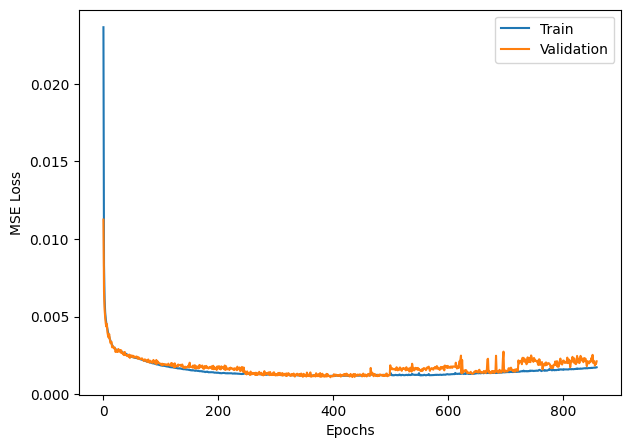

In [ ]:
# MSE Train and validation loss
plt.subplots(figsize=(7, 5))
plt.plot(train_mse, label = "Train")
plt.plot(val_mse, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.savefig("/content/drive/MyDrive/Capstone/16_clstm.png")
plt.show()



#Testing

In [ ]:
class Test():
  def __init__(self, model, start_time, num_input_pics, end_time,new_img_channel,old_img_height,old_img_width,
               new_img_height,new_img_width, model_path, out_path):
    self.model = model 
    self.start_time = start_time
    self.num_input_pics = num_input_pics
    self.end_time = end_time

    self.new_img_channel = new_img_channel 
    self.old_img_height = old_img_height
    self.old_img_width = old_img_width
    self.new_img_height = new_img_height 
    self.new_img_width = new_img_width
    self.model_path = model_path
    self.out_path = out_path
    self.use_cuda = True
  def test(self):
    
    self.model.eval()
    with torch.no_grad():
      for batch in test_dl:
        y_idx = batch[0].tolist()
        num_series = len(y_idx)
        x_test = self.create_x_arr(num_series, self.num_input_pics,self.new_img_channel,self.old_img_height,self.old_img_width,y_idx)
        for timestep in range(self.start_time, self.end_time):

          self.__real_y_generator__(y_idx,self.model_path, timestep)
          if self.use_cuda:
            x_test = x_test.cuda()

          x_test = fn.center_crop(x_test, output_size = [256])
          

          n_series_test = x_test.shape[0]

          x_test_new_dim = (n_series_test*self.num_input_pics, self.new_img_channel, self.new_img_height, self.new_img_width)
          x_test_new = torch.reshape(x_test,x_test_new_dim)
          
          y_test_predict = self.model(x_test_new)
          
          y_test_predict_crop = fn.center_crop(y_test_predict, output_size = [256])
          self.__save_y_pred__(y_test_predict_crop, timestep, y_idx)

          y_test_pred_crop_new_dim = (n_series_test, 1, self.new_img_channel, self.new_img_height, self.new_img_width)
          y_test_crop_reshape = torch.reshape(y_test_predict_crop, y_test_pred_crop_new_dim)


          x_test = torch.cat((x_test, y_test_crop_reshape), dim = 1)
          x_test = x_test[:,-self.num_input_pics:,:,:,:]

  def create_x_arr(self,num_series,num_input_pics, img_channel, img_height, img_width, y_idx):
    x_arr = np.zeros(shape=(num_series,num_input_pics,img_channel,img_height,img_width))
    for series in range(num_series): 
      for input in range(num_input_pics): 
        model_path = self.model_path +str(y_idx[series])
        x_to_convert = Image.open(model_path+'/'+"{:02d}".format(input)+'im.jpg')
        x = np.asarray(x_to_convert)
        x = np.moveaxis(x,-1,0) # change image dimension to channel first
        x_arr[series][input] = x
    x_arr = (np.array(x_arr)/255).astype(np.float32)
    return torch.tensor(x_arr)

  def __real_y_generator__(self, y_index_list, model_path, timestep):
    # get the y_img
    
    for series_num in y_index_list:
      out_path = self.out_path+"/"+str(series_num)
      outExist = os.path.exists(out_path)
      model_path = self.model_path + str(series_num)
      
      if not outExist:
        os.makedirs(out_path)
      y_real = Image.open(model_path+'/'+"{:02d}".format(timestep)+'im.jpg')
      width, height = 432,288 
      new_size = 256
      left = (width - new_size) / 2
      top = (height - new_size) / 2
      right = (width + new_size) / 2
      bottom = (height + new_size) / 2
      cropped_image = Image.fromarray(np.asarray(y_real.crop((left, top, right, bottom))))
      cropped_image.save(out_path+'/'+"{:02d}".format(timestep)+'_real.jpg')

  def __save_y_pred__(self, y_test_predict_crop, timestep, y_index_list):

    imgs_out = y_test_predict_crop*255
    imgs_out = imgs_out.cpu().numpy()
    imgs_out = np.moveaxis(imgs_out,1,3)

    imgs_out = np.uint8(imgs_out)

    for img_num in range(imgs_out.shape[0]):
      series_num = y_index_list[img_num]
      out_p = self.out_path+"/"+str(series_num)
      img_out = imgs_out[img_num]
      img_out = Image.fromarray(img_out)
      img_out.save(out_p+'/'+"{:02d}".format(timestep)+'_pred.jpg')



In [ ]:
trained_model = g_model
start_time = 7
num_input_pics = 7
end_time = 100


img_channel = 3
img_height = 256
img_width = 256

old_img_height = 288
old_img_width = 432
model_path = "/content/drive/MyDrive/Capstone/Capstone_data_jpg/"
out_path = "/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/16_clstm_lsgan_500"

tester = Test(trained_model, start_time,num_input_pics,end_time,img_channel,old_img_height, old_img_width, img_height,img_width, model_path, out_path)
tester.test()